# **Import Dependencies**

In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00a 0:00:01


# **Import Modules**

In [2]:
import os
import random
import cv2
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Load The Dataset**

In [3]:
LANE_DATASET_PATH = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset"
LANE_YAML_PATH = os.path.join(LANE_DATASET_PATH, "dataset.yaml")

print("Lane Dataset Path:", LANE_DATASET_PATH)
print("YAML Path:", LANE_YAML_PATH)

Lane Dataset Path: /kaggle/input/road-lane-segmentation-imgs-and-labels/dataset
YAML Path: /kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/dataset.yaml


# **Data Preprocessing**

In [4]:
# Dataset in Kaggle input
LANE_DATASET_PATH = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset"

# Save fixed yaml in working
NEW_YAML_PATH = "/kaggle/working/lane_dataset.yaml"

data = {
    "path": LANE_DATASET_PATH,
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 1,
    "names": ["Lane"]
}

with open(NEW_YAML_PATH, "w") as f:
    yaml.dump(data, f)

print("✅ New YAML created:", NEW_YAML_PATH)

✅ New YAML created: /kaggle/working/lane_dataset.yaml


In [5]:
# # ==================================================
# # FIX / OVERWRITE dataset.yaml
# # ==================================================
# data = {
#     "path": LANE_DATASET_PATH,     # root folder
#     "train": "train/images",
#     "val": "valid/images",         # sometimes dataset uses 'valid'
#     "test": "test/images",
#     "nc": 1,
#     "names": ["lane"]
# }

# with open(LANE_YAML_PATH, "w") as f:
#     yaml.dump(data, f, default_flow_style=False)

# print("✅ YAML fixed:", LANE_YAML_PATH)

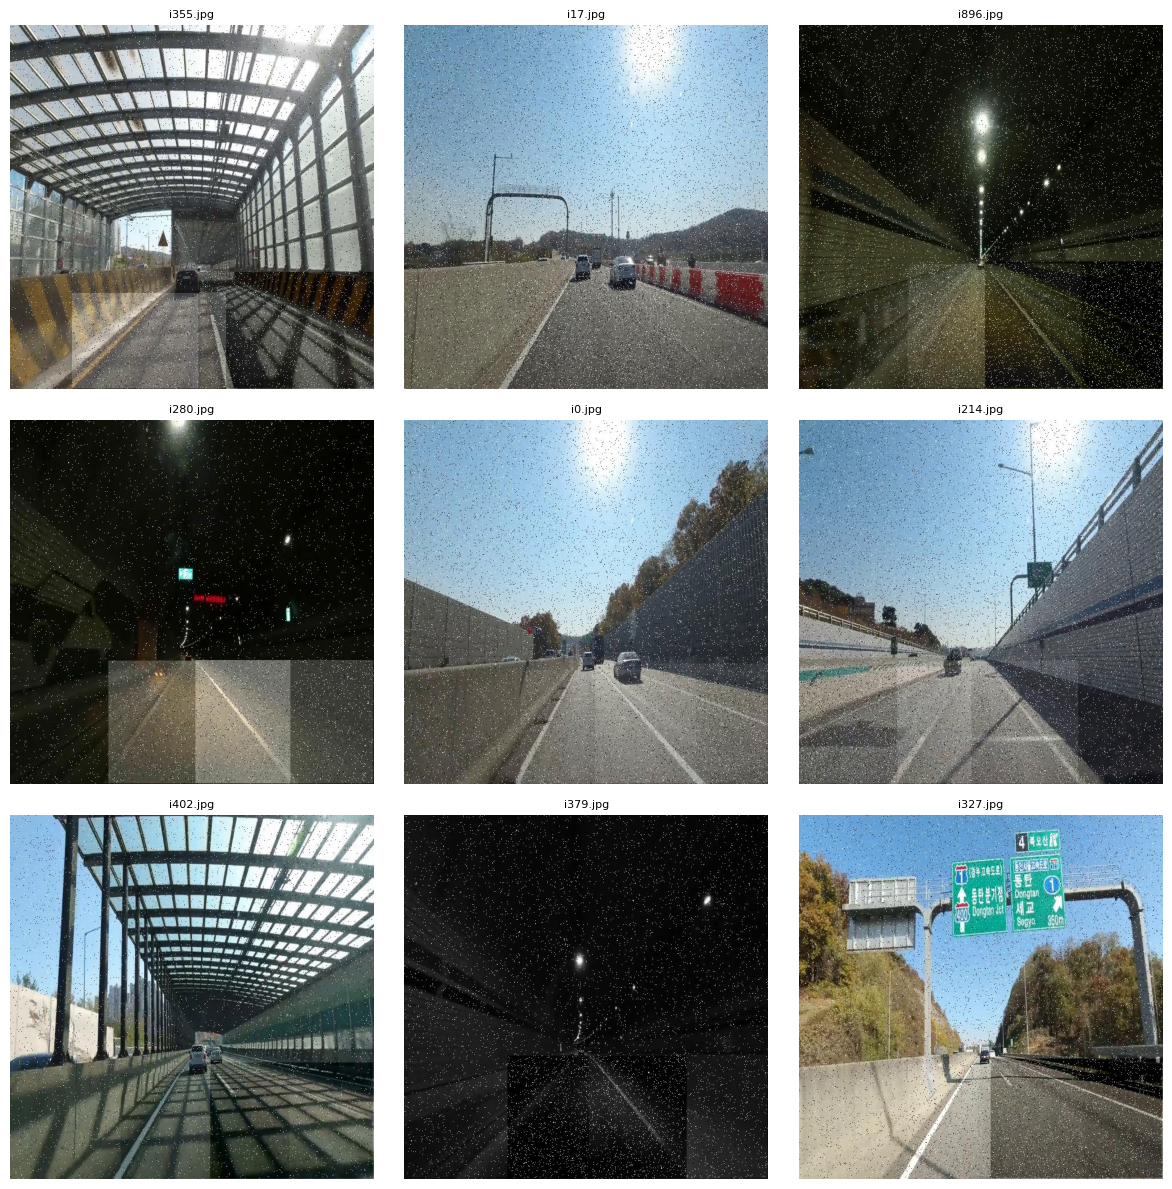

In [6]:
TRAIN_IMG_DIR = '/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/train/images'

train_images = os.listdir(TRAIN_IMG_DIR)
sample_imgs = random.sample(train_images, 9)

plt.figure(figsize=(12, 12))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


# **Model Building**

In [7]:
# Train
model = YOLO("yolo11s-seg.pt")

In [8]:
results = model.train(
    data=NEW_YAML_PATH,
    epochs=50, 
    imgsz=640,
    batch=16,
    device=0,
    cache=True,
    name="lane_seg_train",
    exist_ok=True
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/lane_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=lane_seg_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

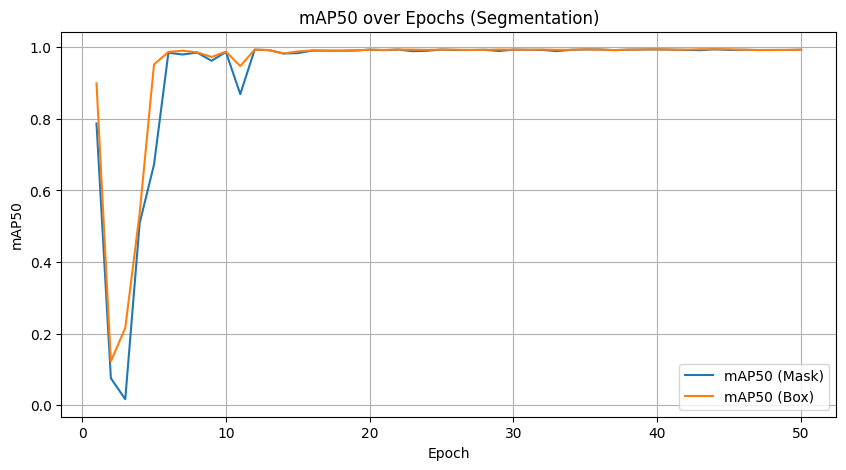

In [9]:
# ==========================================================
# PLOT TRAINING RESULTS
# ==========================================================
results_csv = "/kaggle/working/runs/segment/lane_seg_train/results.csv"
df = pd.read_csv(results_csv)

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["metrics/mAP50(M)"], label="mAP50 (Mask)")
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50 (Box)")
plt.title("mAP50 over Epochs (Segmentation)")
plt.xlabel("Epoch")
plt.ylabel("mAP50")
plt.grid(True)
plt.legend()
plt.show()


# **Model Evaluation**

In [10]:
# ==========================================================
#  LOAD BEST MODEL
# ==========================================================
BEST_MODEL_PATH = "/kaggle/working/runs/segment/lane_seg_train/weights/best.pt"
best_model = YOLO(BEST_MODEL_PATH)

print("✅ Best segmentation model loaded:", BEST_MODEL_PATH)

✅ Best segmentation model loaded: /kaggle/working/runs/segment/lane_seg_train/weights/best.pt


In [11]:
# ==========================================================
# EVALUATE ON TEST DATASET
# ==========================================================
best_model.val(
    data=NEW_YAML_PATH,   # your fixed yaml path
    split="test"
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s-seg summary (fused): 114 layers, 10,067,203 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 17.8±4.5 MB/s, size: 134.0 KB)
val: Scanning /kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/test/labels... 103 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 103/103 167.1it/s 0.6s1s
WARNING ⚠️ val: Cache directory /kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.2it/s 3.2s0.5ss
                   all        103        206          1          1      0.995       0.99      0.995      0.995      0.995      0.984
Speed: 3.5ms preprocess, 14.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/val


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5d8995f5f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

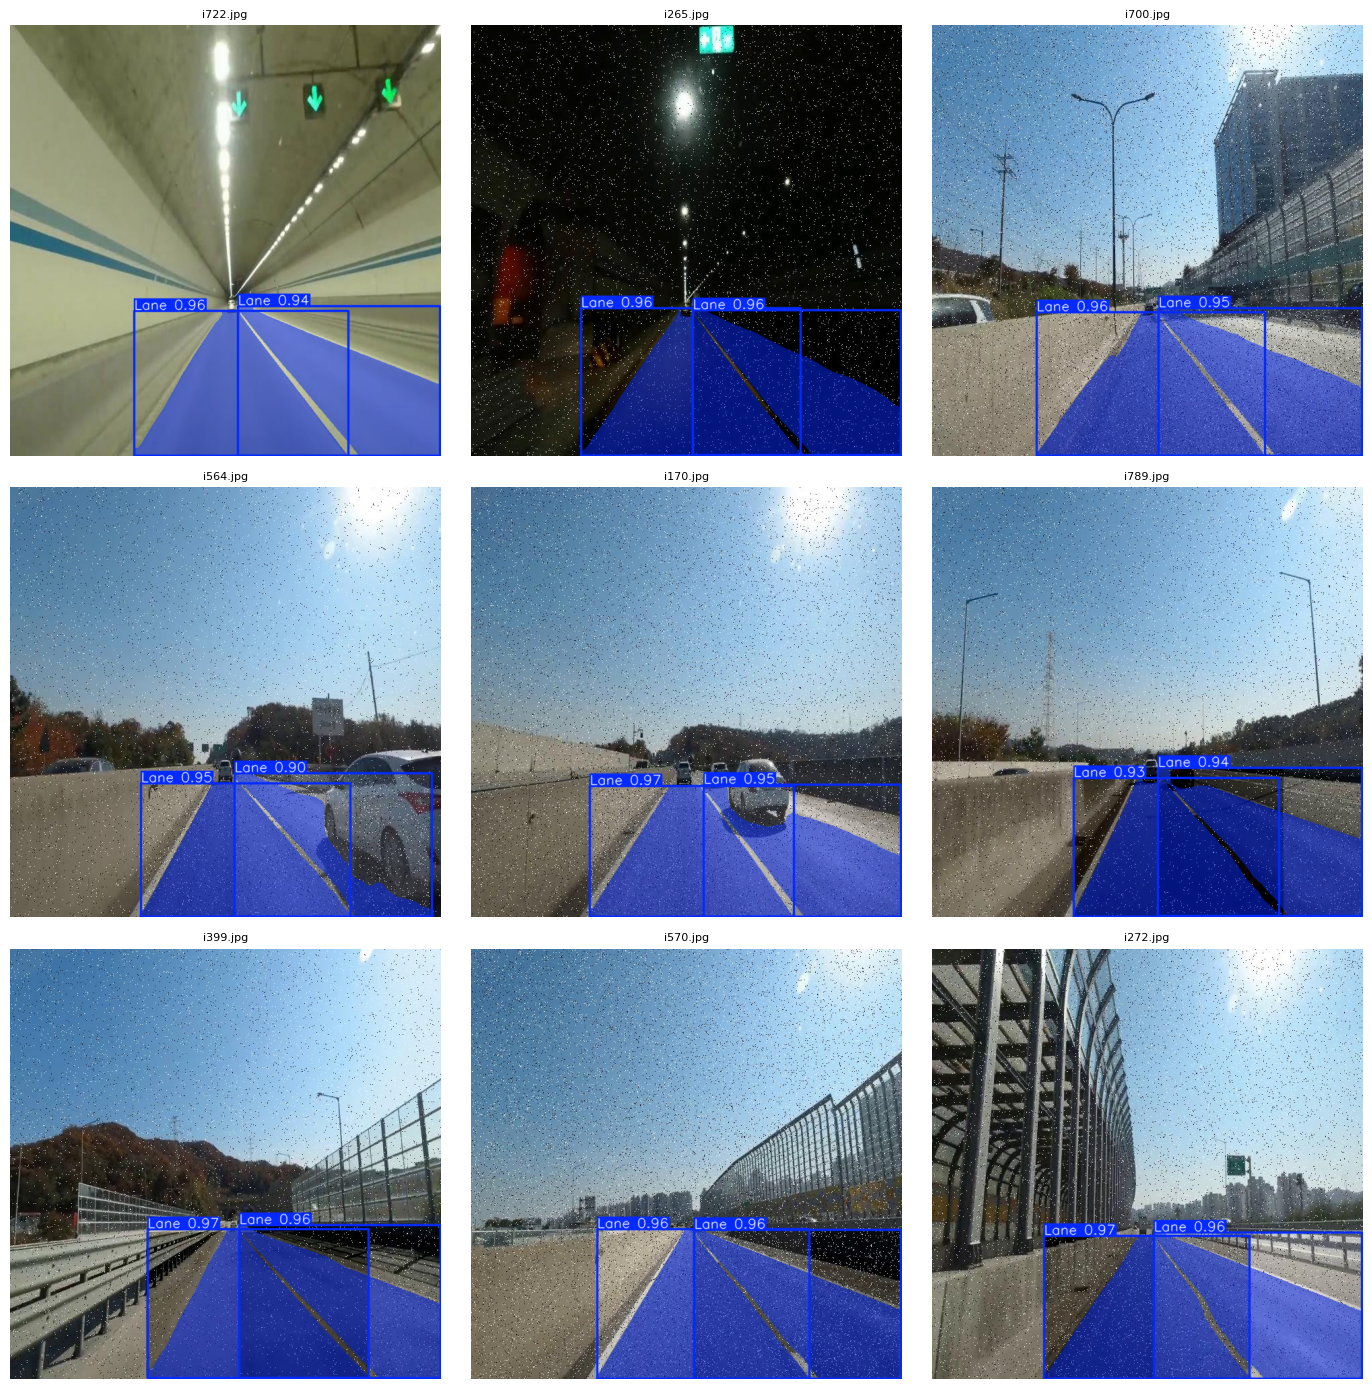

In [12]:
# ==========================================================
# VISUALIZE RANDOM TEST PREDICTIONS
# ==========================================================
TEST_IMG_DIR = "/kaggle/input/road-lane-segmentation-imgs-and-labels/dataset/test/images"

test_images = os.listdir(TEST_IMG_DIR)
sample_test_imgs = random.sample(test_images, 9)

plt.figure(figsize=(14, 14))

for i, img_name in enumerate(sample_test_imgs):
    img_path = os.path.join(TEST_IMG_DIR, img_name)

    result = best_model.predict(img_path, conf=0.4, imgsz=640, verbose=False)[0]

    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i+1)
    plt.imshow(annotated_img)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()